## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Get a Census API key and replace it in the cell below

In [4]:
%%R 

census_api_key("a435d72f84653a5895173d187536a34d55ac0afc") # <- Insert your Census API key here

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [17]:
%%R 
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",     # population
                        total_units = "B25001_001",  # housing units
                        love="B12001_001"         # Age at First Marriage
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

names(nyc_census_data)

nyc_census_data


Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
1  36081014700  Census Tract 147, Queens County, New York  population     2863
2  36081014700  Census Tract 147, Queens County, New York        love     2549
3  36081014700  Census Tract 147, Queens County, New York total_units     1570
4  36047058400   Census Tract 584, Kings County, New York  population     3655
5  36047058400   Census Tract 584, Kings County, New York        love     2914
6  36047058400   Census Tract 584, Kings County, New York total_units     1498
7  36061006900 Census Tract 69, New York County, New York  population     2450
8  36061006900 Census Tract 69, New York County, New York        love     2232
9  36061006900 Census Tract 69, New York Co

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [18]:
%%R 
library(tigris)
library(sf)

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID       NAME                   geometry population_estimate love_estimate
   <chr>       <chr>        <MULTIPOLYGON [°]>               <dbl>         <dbl>
 1 36081014700 Cens… (((-73.9137 40.76548, -7…                2863          2549
 2 36047058400 Cens… (((-73.96103 40.59616, -…                3655          2914
 3 36061006900 Cens… (((-74.02064 40.73039, -…                2450          2232
 4 36047073000 Cens… (((-73.93345 40.6257, -7…                2676          2361
 5 36047100400 Cens… (((-73.90735 40.63083, -…                3004          2338
 6 36047055700 Cens… (((-73.96279 40.72256, -…                1834          1686
 7 36005022101 Cens… (((-73.92012 40.83759, -…                4030          2889
 8 36081047000 Cens… (((

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [19]:
%%R 
nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    ) 

nyc_census_data


Simple feature collection with 2327 features and 9 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83


# A tibble: 2,327 × 10
   GEOID       NAME                   geometry population_estimate love_estimate
 * <chr>       <chr>        <MULTIPOLYGON [°]>               <dbl>         <dbl>
 1 36081014700 Cens… (((-73.9137 40.76548, -7…                2863          2549
 2 36047058400 Cens… (((-73.96103 40.59616, -…                3655          2914
 3 36061006900 Cens… (((-74.02064 40.73039, -…                2450          2232
 4 36047073000 Cens… (((-73.93345 40.6257, -7…                2676          2361
 5 36047100400 Cens… (((-73.90735 40.63083, -…                3004          2338
 6 36047055700 Cens… (((-73.96279 40.72256, -…                1834          1686
 7 36005022101 Cens… (((-73.92012 40.83759, -…                4030          2889
 8 36081047000 Cens… (((-73.78059 40.71343, -…                3637          2940
 9 36047050402 Cens… (((-73.97496 40.6478, -7…                1758          1545
10 36047028501 Cens… (((-73.94439 40.70043, -…                 356           356
# ℹ 2

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

In [20]:
%%R -w 1000

ggplot()

    nyc_census_data <- nyc_census_data %>% 
        mutate(
            borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim(),
            units_per_person = total_units_estimate / population_estimate
        ) 

    nyc_census_data


Simple feature collection with 2327 features and 10 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 11
   GEOID       NAME                   geometry population_estimate love_estimate
 * <chr>       <chr>        <MULTIPOLYGON [°]>               <dbl>         <dbl>
 1 36081014700 Cens… (((-73.9137 40.76548, -7…                2863          2549
 2 36047058400 Cens… (((-73.96103 40.59616, -…                3655          2914
 3 36061006900 Cens… (((-74.02064 40.73039, -…                2450          2232
 4 36047073000 Cens… (((-73.93345 40.6257, -7…                2676          2361
 5 36047100400 Cens… (((-73.90735 40.63083, -…                3004          2338
 6 36047055700 Cens… (((-73.96279 40.72256, -…                1834          1686
 7 36005022101 Cens… (((-73.92012 40.83759, -…                4030          2889
 8 36081047000 Cens… (

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 88 rows containing non-finite values (`stat_bin()`). 



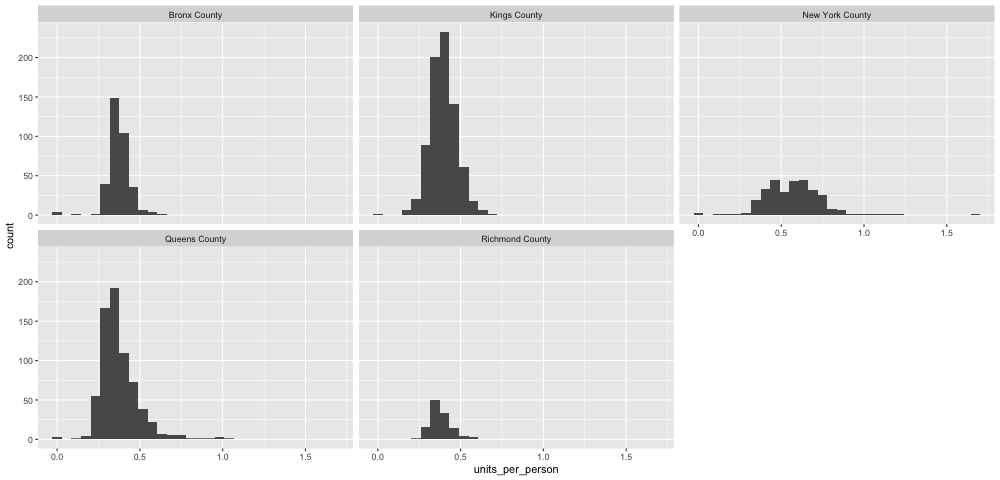

In [24]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=units_per_person) +
    geom_histogram() + 
    facet_wrap(~borough) 

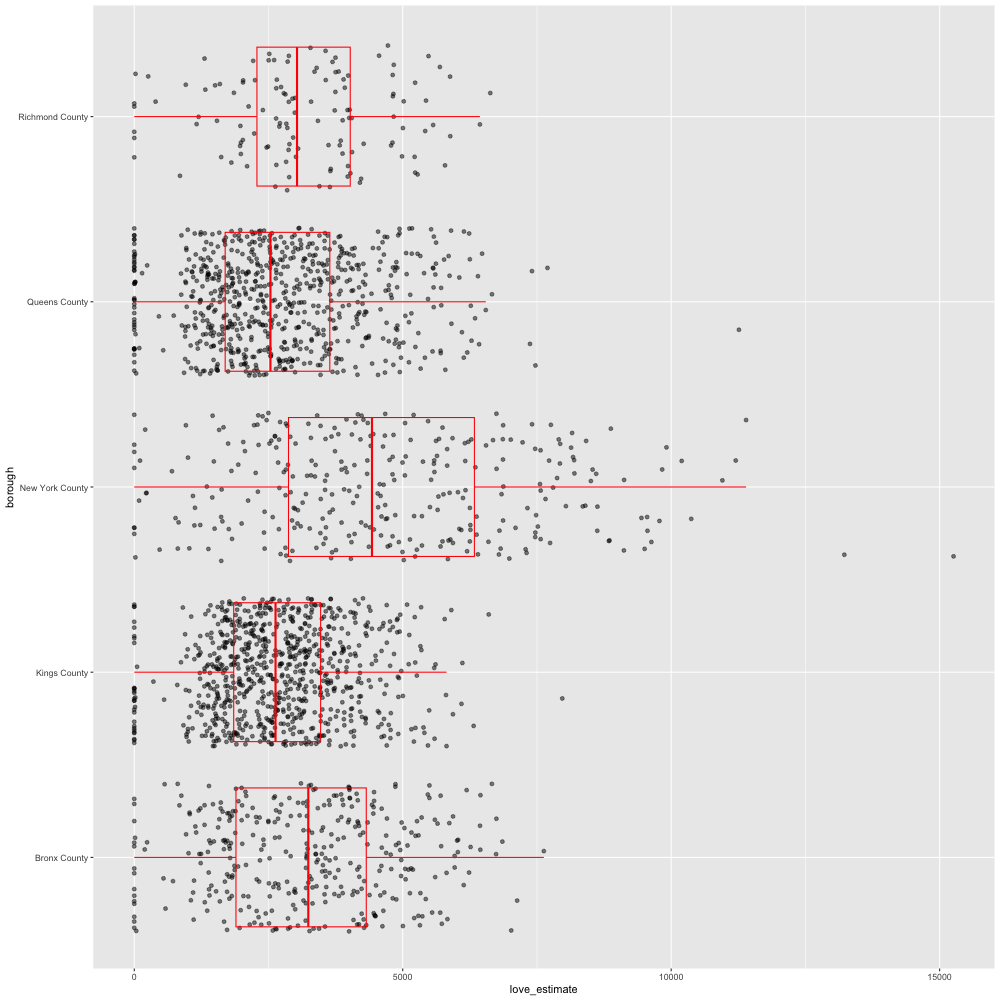

In [21]:
%%R -w 1000 -h 1000

ggplot(nyc_census_data) + 
    aes(x=love_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 


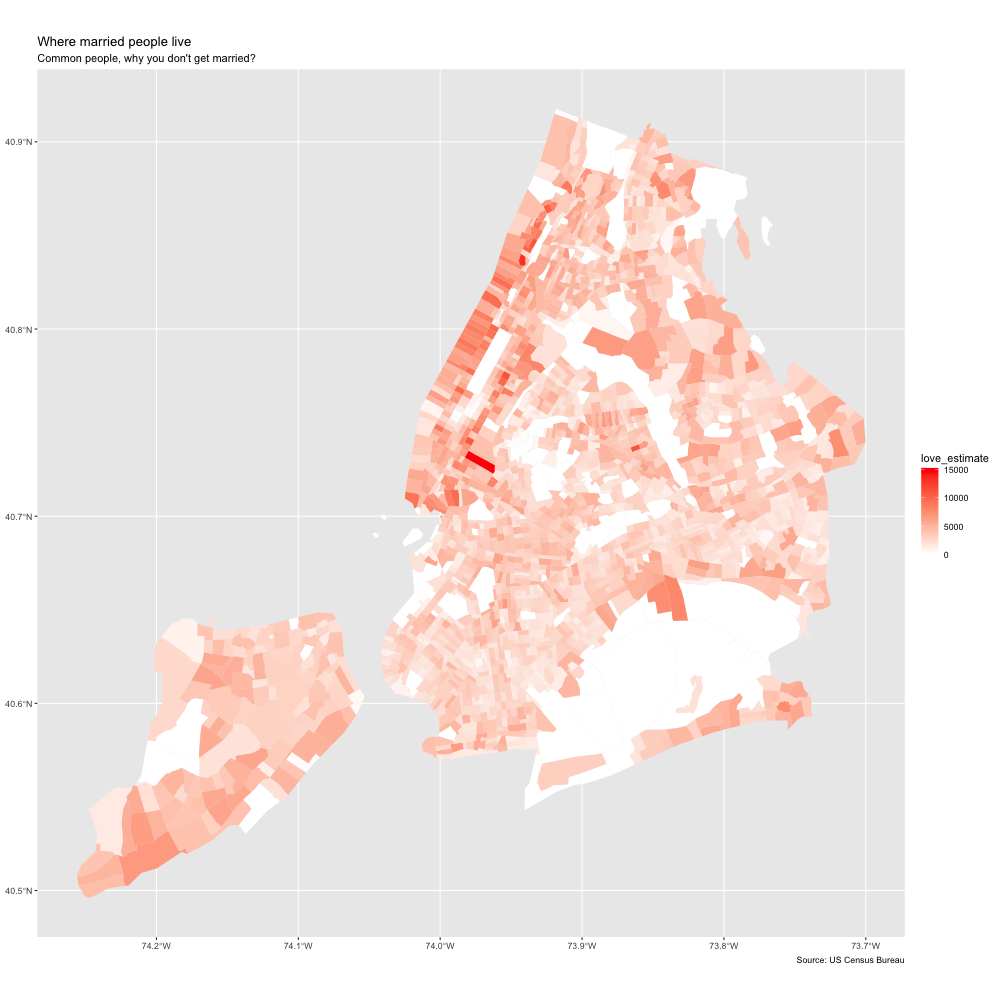

In [22]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = love_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "Where married people live",
    subtitle = "Common people, why you don't get married?",
    caption = "Source: US Census Bureau"
  )
